## Make Diagnostic Plots for NA-CORDEX Zarr Stores

In [1]:
import xarray as xr
import numpy as np

import pprint
import json

### Use Dask to Speed up Computations

In [2]:
import dask
from ncar_jobqueue import NCARCluster

# Processes is processes PER CORE.
# This one works fine.
#cluster = NCARCluster(cores=15, processes=1, memory='100GB', project='STDD0003')
# This one also works, but occasionally hangs near the end.
#cluster = NCARCluster(cores=10, processes=1, memory='50GB', project='STDD0003')

num_jobs=10
cluster = NCARCluster(cores=num_jobs, processes=1, memory='10GB', project='STDD0003')
cluster.scale(jobs=num_jobs)

from distributed import Client
from distributed.utils import format_bytes
client = Client(cluster)
cluster

### Run first over a single Zarr Store.

In [3]:
# For now, make the Zarr output directory a global variable.
dirout = '/glade/scratch/bonnland/na-cordex/zarr-demo'

from pathlib import Path
p = Path(dirout)
#stores = list(p.rglob("*.zarr"))
stores = list(p.rglob("tasmax*.zarr"))
for store in stores:
    print(f'Opening {store}...')
    try:
        ds = xr.open_zarr(store.as_posix(), consolidated=True)
        print('\n')
    except Exception as e:
        print(e)
    break
ds

Opening /glade/scratch/bonnland/na-cordex/zarr-demo/tasmax.rcp85.day.NAM-22i.raw.zarr...




<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 258, lon: 600, member_id: 16, time: 34698)
Coordinates:
  * lat        (lat) float64 12.12 12.38 12.62 12.88 ... 75.62 75.88 76.12 76.38
  * lon        (lon) float64 -171.9 -171.6 -171.4 ... -22.62 -22.38 -22.12
  * member_id  (member_id) <U21 'MPI-ESM-MR.CRCM5-UQAM' ... 'MPI-ESM-LR.WRF'
  * time       (time) datetime64[ns] 2006-01-01T12:00:00 ... 2100-12-31T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(17349, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tasmax     (member_id, time, lat, lon) float32 dask.array<chunksize=(4, 1000, 65, 120), meta=np.ndarray>
Attributes:
    CORDEX_domain:                  NAM-22
    contact:                        {"MPI-ESM-MR.CRCM5-UQAM": "Winger.Katja@u...
    creation_date:                  {"MPI-ESM-MR.CRCM5-UQAM": "2017-11-07T11:...
    driving_experiment:             {"MPI-ESM-MR.CRCM5-UQAM": "MPI-M-MPI-ESM-...
    driving_experiment_name:        rcp85
    driving_model_ensemble_member:  {"MPI-ESM-MR.CRCM5-UQAM": "r1i1p1", "GEMa...
    driving_model_id:               {"MPI-ESM-MR.CRCM5-UQAM": "MPI-M-MPI-ESM-...
    experiment:                     rcp85
    experiment_id:                  rcp85
    frequency:                      day
    id:                             doi:10.5065/D6SJ1JCH
    institute_id:                   {"MPI-ESM-MR.CRCM5-UQAM": "UQAM", "GEMatm...
    institution:                    {"MPI-ESM-MR.CRCM5-UQAM": "Universite du ...
    model_id:                       {"MPI-ESM-MR.CRCM5-UQAM": "UQAM-CRCM5", "...
    product:                        output
    project_id:                     CORDEX
    rcm_version_id:                 {"MPI-ESM-MR.CRCM5-UQAM": "v1", "GEMatm-C...
    references:                     {"MPI-ESM-MR.CRCM5-UQAM": "http://www.mrc...
    title:                          {"MPI-ESM-MR.CRCM5-UQAM": "NA-CORDEX Raw ...
    tracking_id:                    {"MPI-ESM-MR.CRCM5-UQAM": "92dd13d5-7930-...
    version:                        {"MPI-ESM-MR.CRCM5-UQAM": "3.1", "GEMatm-...

### Gather Variable Names from the Zarr Store

In [10]:
data_vars = [vname for vname in ds.data_vars]
data_var = data_vars[0]

member_names = ds.coords['member_id'].values

numEnsembleMembers = member_names.size

store_name = store.as_posix()
store_name = store_name.split('/')[-1]
store_name

'tasmax.rcp85.day.NAM-22i.raw.zarr'

## Create Time Series Plots from Zarr Store

In [ ]:
import matplotlib.pyplot as plt

# Generate plot. 
#
# With 30 workers, expect 1 minute walltime for computation and 1-2 minutes for plot rendering.
#
numPlotRows = numEnsembleMembers
numPlotCols = 4

figWidth = 200 #100 
figHeight = 80

linestyle = 'k.'
linewidth = 0.5
markersize = 0.5

for var in data_vars:

    fig, axs = plt.subplots(numPlotRows, numPlotCols, figsize=(figWidth,figHeight), sharey='col')

    for index in range(numEnsembleMembers):
        mem_id = member_names[index]
        data_slice = ds[var].sel(member_id=mem_id)

        data_agg = data_slice.min(dim=['lat', 'lon'])
        axs[index, 0].plot(ds.time, data_agg, linewidth=linewidth)
        axs[index, 0].plot(ds.time, data_agg, linestyle, markersize=markersize)
        axs[index, 0].set_ylabel(mem_id, fontsize=15)

        data_agg = data_slice.max(dim=['lat', 'lon'])
        axs[index, 1].plot(ds.time, data_agg, linewidth=linewidth)
        axs[index, 1].plot(ds.time, data_agg, linestyle, markersize=markersize)
        axs[index, 1].set_ylabel(mem_id, fontsize=15)

        data_agg = data_slice.mean(dim=['lat', 'lon'])
        axs[index, 2].plot(ds.time, data_agg, linewidth=linewidth)
        axs[index, 2].plot(ds.time, data_agg, linestyle, markersize=markersize)
        axs[index, 2].set_ylabel(mem_id, fontsize=15)

        data_agg = data_slice.std(dim=['lat', 'lon'])
        axs[index, 3].plot(ds.time, data_agg, linewidth=linewidth)
        axs[index, 3].plot(ds.time, data_agg, linestyle, markersize=markersize)
        axs[index, 3].set_ylabel(mem_id, fontsize=15)
       
    
    axs[0, 0].set_title(f'min({var})', fontsize=40)
    axs[0, 1].set_title(f'max({var})', fontsize=40)
    axs[0, 2].set_title(f'mean({var})', fontsize=40)
    axs[0, 3].set_title(f'std({var})', fontsize=40)
    

    plt.suptitle(store, fontsize=50)
    plt.tight_layout(pad=20.2, w_pad=5.5, h_pad=5.5)
    plt.savefig(f'{store}_ts.pdf')



## Create Spatial Plots from Zarr Store

In [ ]:
import matplotlib.pyplot as plt

# Generate plot. 
#
# With 30 workers, expect 1 minute walltime for computation and 1-2 minutes for plot rendering.
#

numPlotRows = numEnsembleMembers
numPlotCols = 4

figWidth = 17 
figHeight = 35


for var in data_vars:

    fig, axs = plt.subplots(numPlotRows, numPlotCols, figsize=(figWidth,figHeight), constrained_layout=True)

    for index in range(numEnsembleMembers):
        mem_id = member_names[index]
        data_slice = ds[var].sel(member_id=mem_id)

        data_agg = data_slice.min(dim='time')
        pcm0 = axs[index, 0].imshow(data_agg, origin='lower')
        axs[index, 0].set_ylabel(mem_id, fontsize=8)

        data_agg = data_slice.max(dim='time')
        pcm1 = axs[index, 1].imshow(data_agg, origin='lower')
        axs[index, 1].set_ylabel(mem_id, fontsize=8)

        data_agg = data_slice.mean(dim='time')
        pcm2 = axs[index, 2].imshow(data_agg, origin='lower')
        axs[index, 2].set_ylabel(mem_id, fontsize=8)

        data_agg = data_slice.std(dim='time')
        pcm3 = axs[index, 3].imshow(data_agg, origin='lower')
        axs[index, 3].set_ylabel(mem_id, fontsize=8)
       
    
    axs[0, 0].set_title(f'min({var})', fontsize=15)
    axs[0, 1].set_title(f'max({var})', fontsize=15)
    axs[0, 2].set_title(f'mean({var})', fontsize=15)
    axs[0, 3].set_title(f'std({var})', fontsize=15)
    
    plt.colorbar(pcm0, ax = axs[:, 0], location='bottom', shrink=0.7)
    plt.colorbar(pcm1, ax = axs[:, 1], location='bottom', shrink=0.7)
    plt.colorbar(pcm2, ax = axs[:, 2], location='bottom', shrink=0.7)
    plt.colorbar(pcm3, ax = axs[:, 3], location='bottom', shrink=0.7)

    plt.suptitle(store, fontsize=20)
    plt.savefig(f'{store}_maps.pdf')


In [8]:
store

PosixPath('/glade/scratch/bonnland/na-cordex/zarr-demo/tasmax.rcp85.day.NAM-22i.raw.zarr')

In [9]:
store.as_posix()

'/glade/scratch/bonnland/na-cordex/zarr-demo/tasmax.rcp85.day.NAM-22i.raw.zarr'

## Create Alternate Time Series Plots from Zarr Store

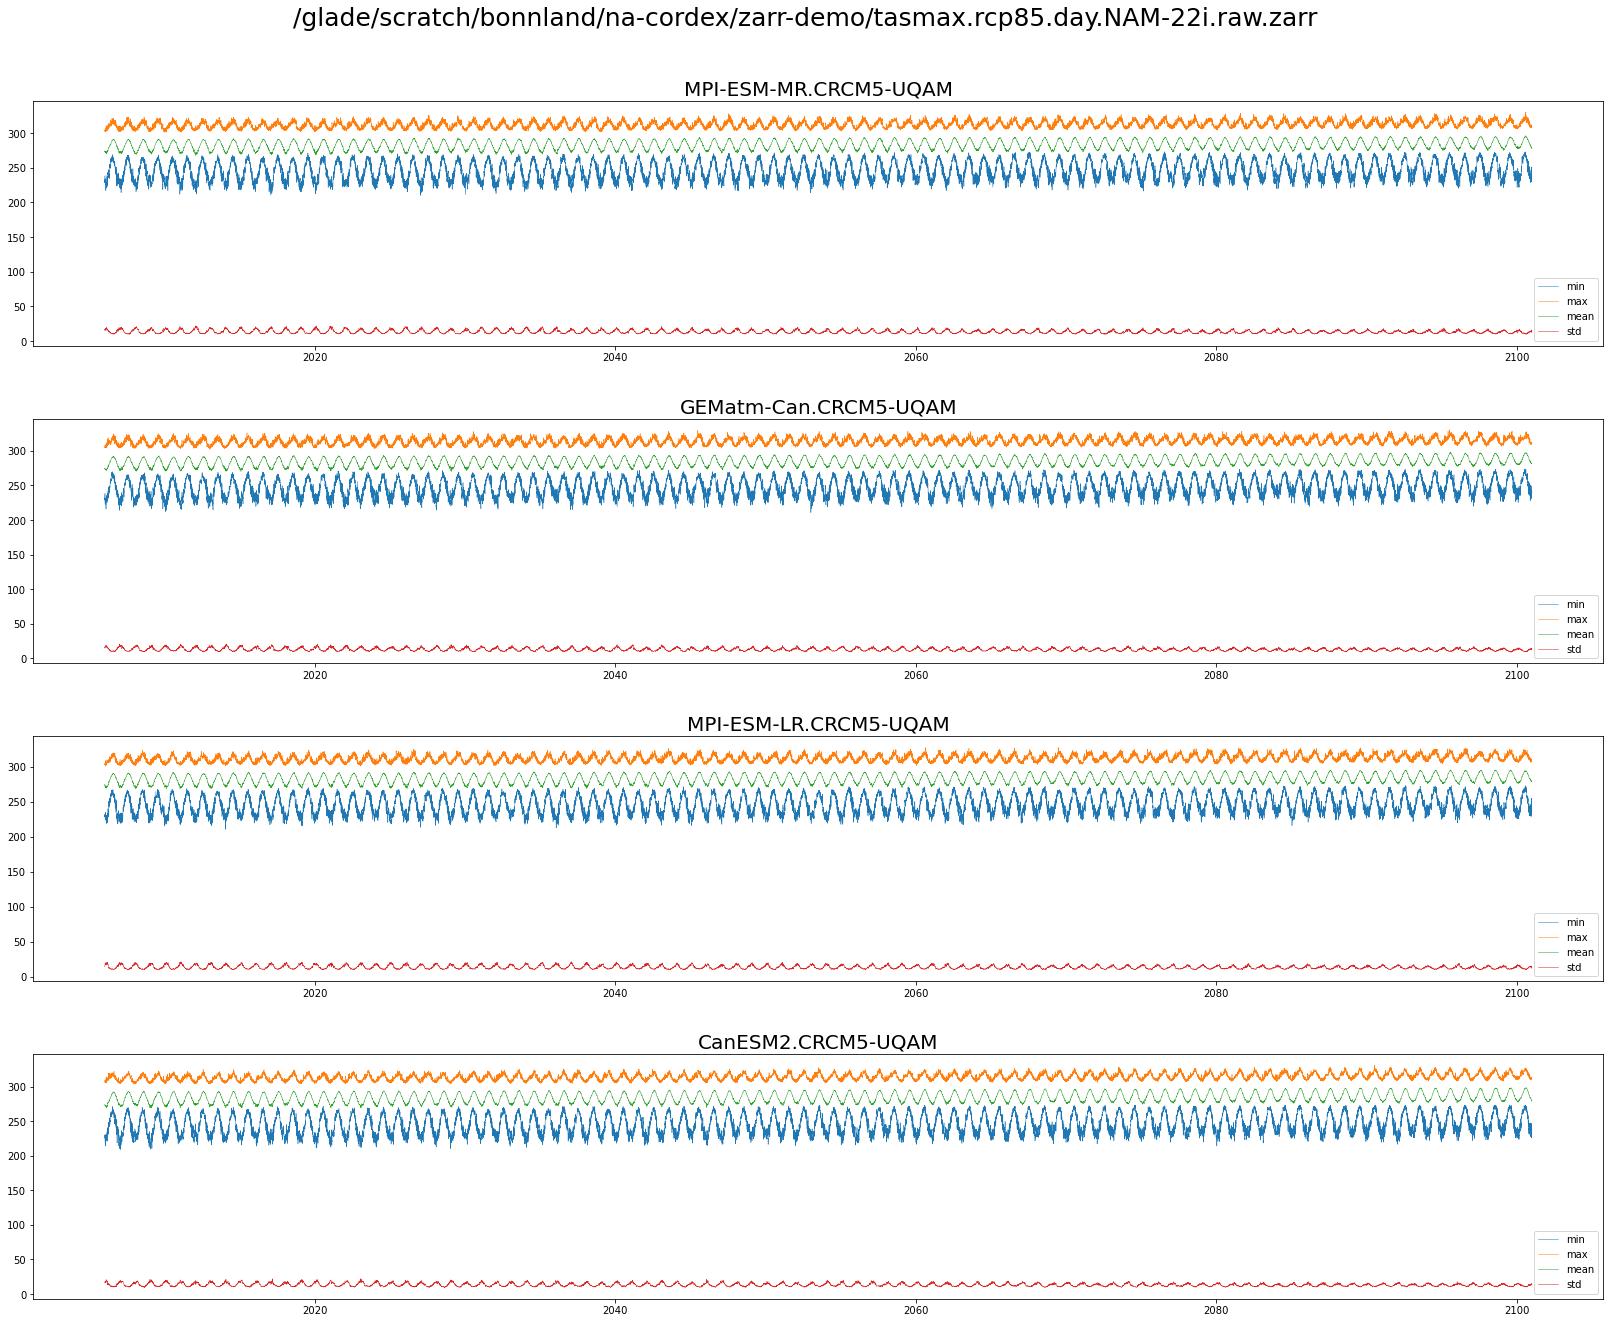

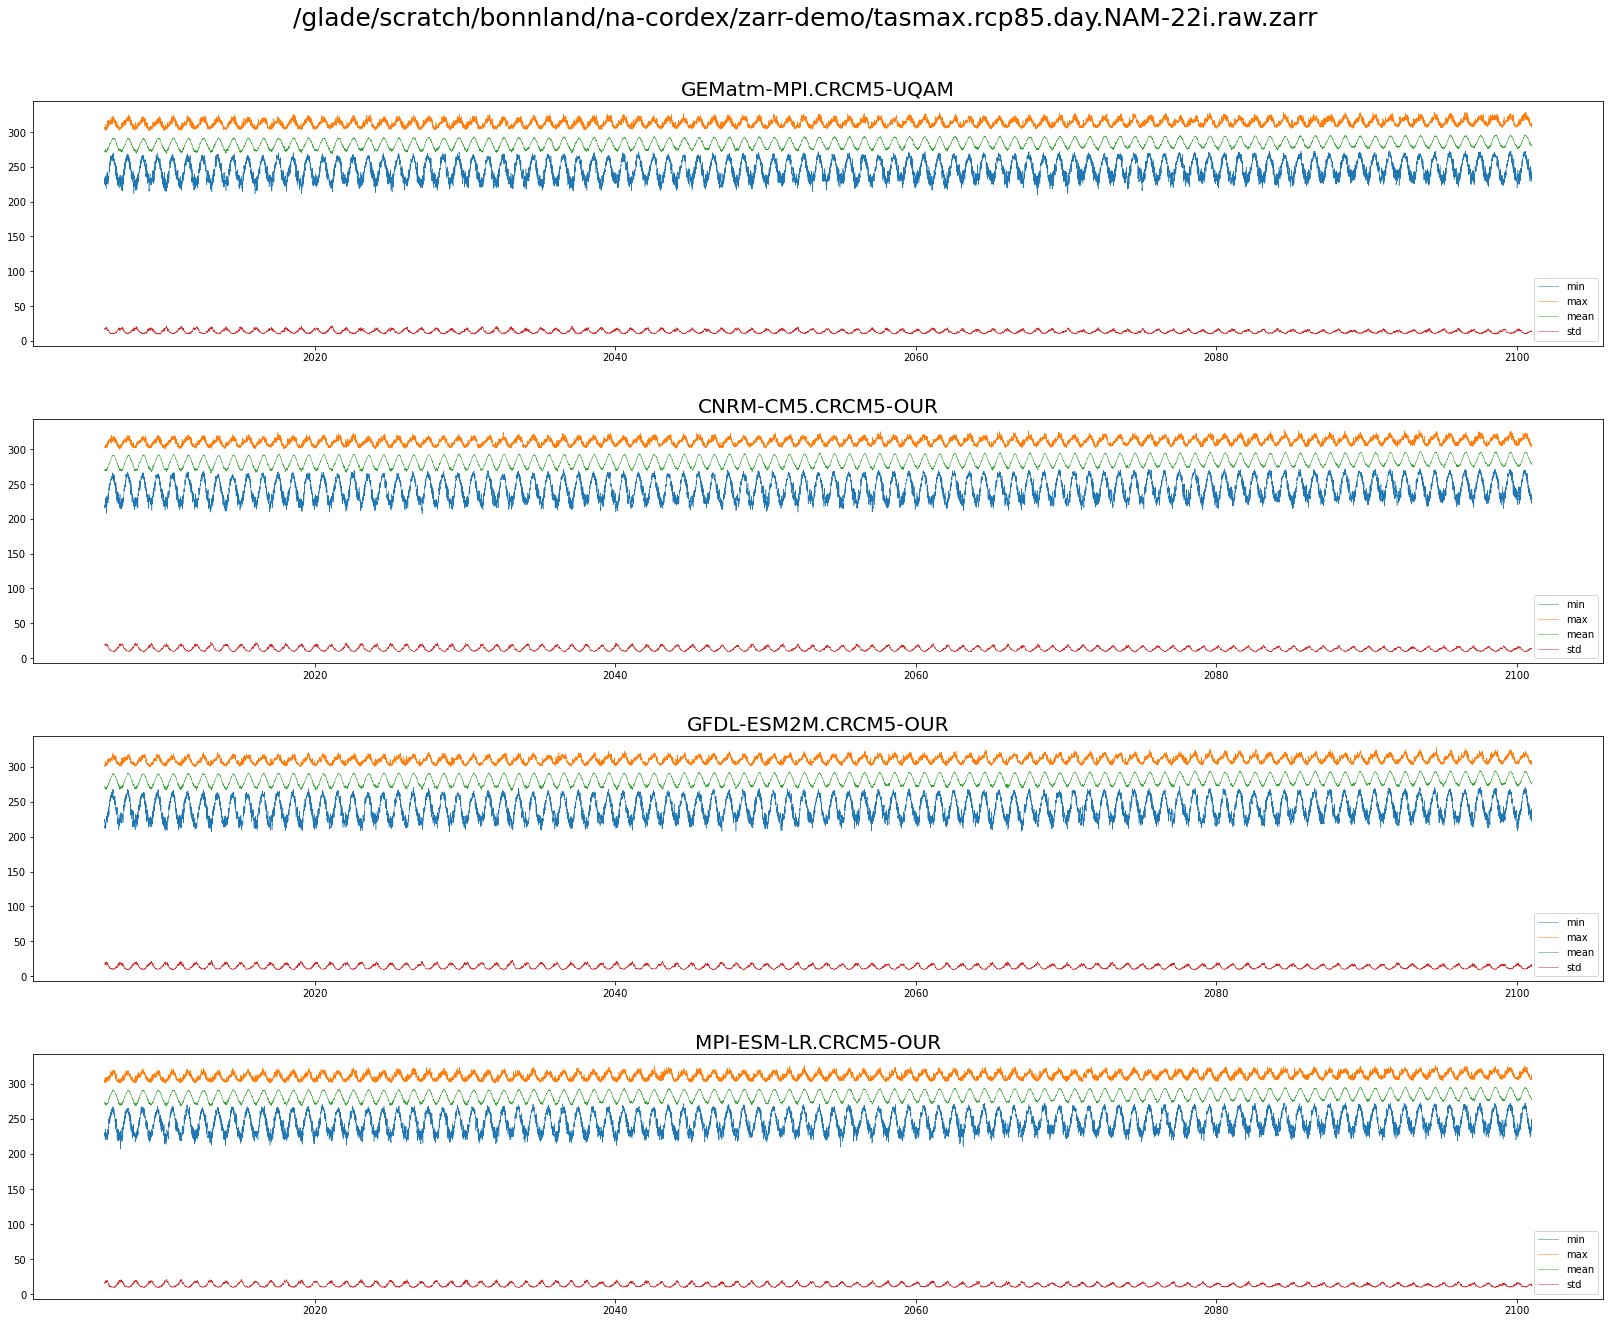

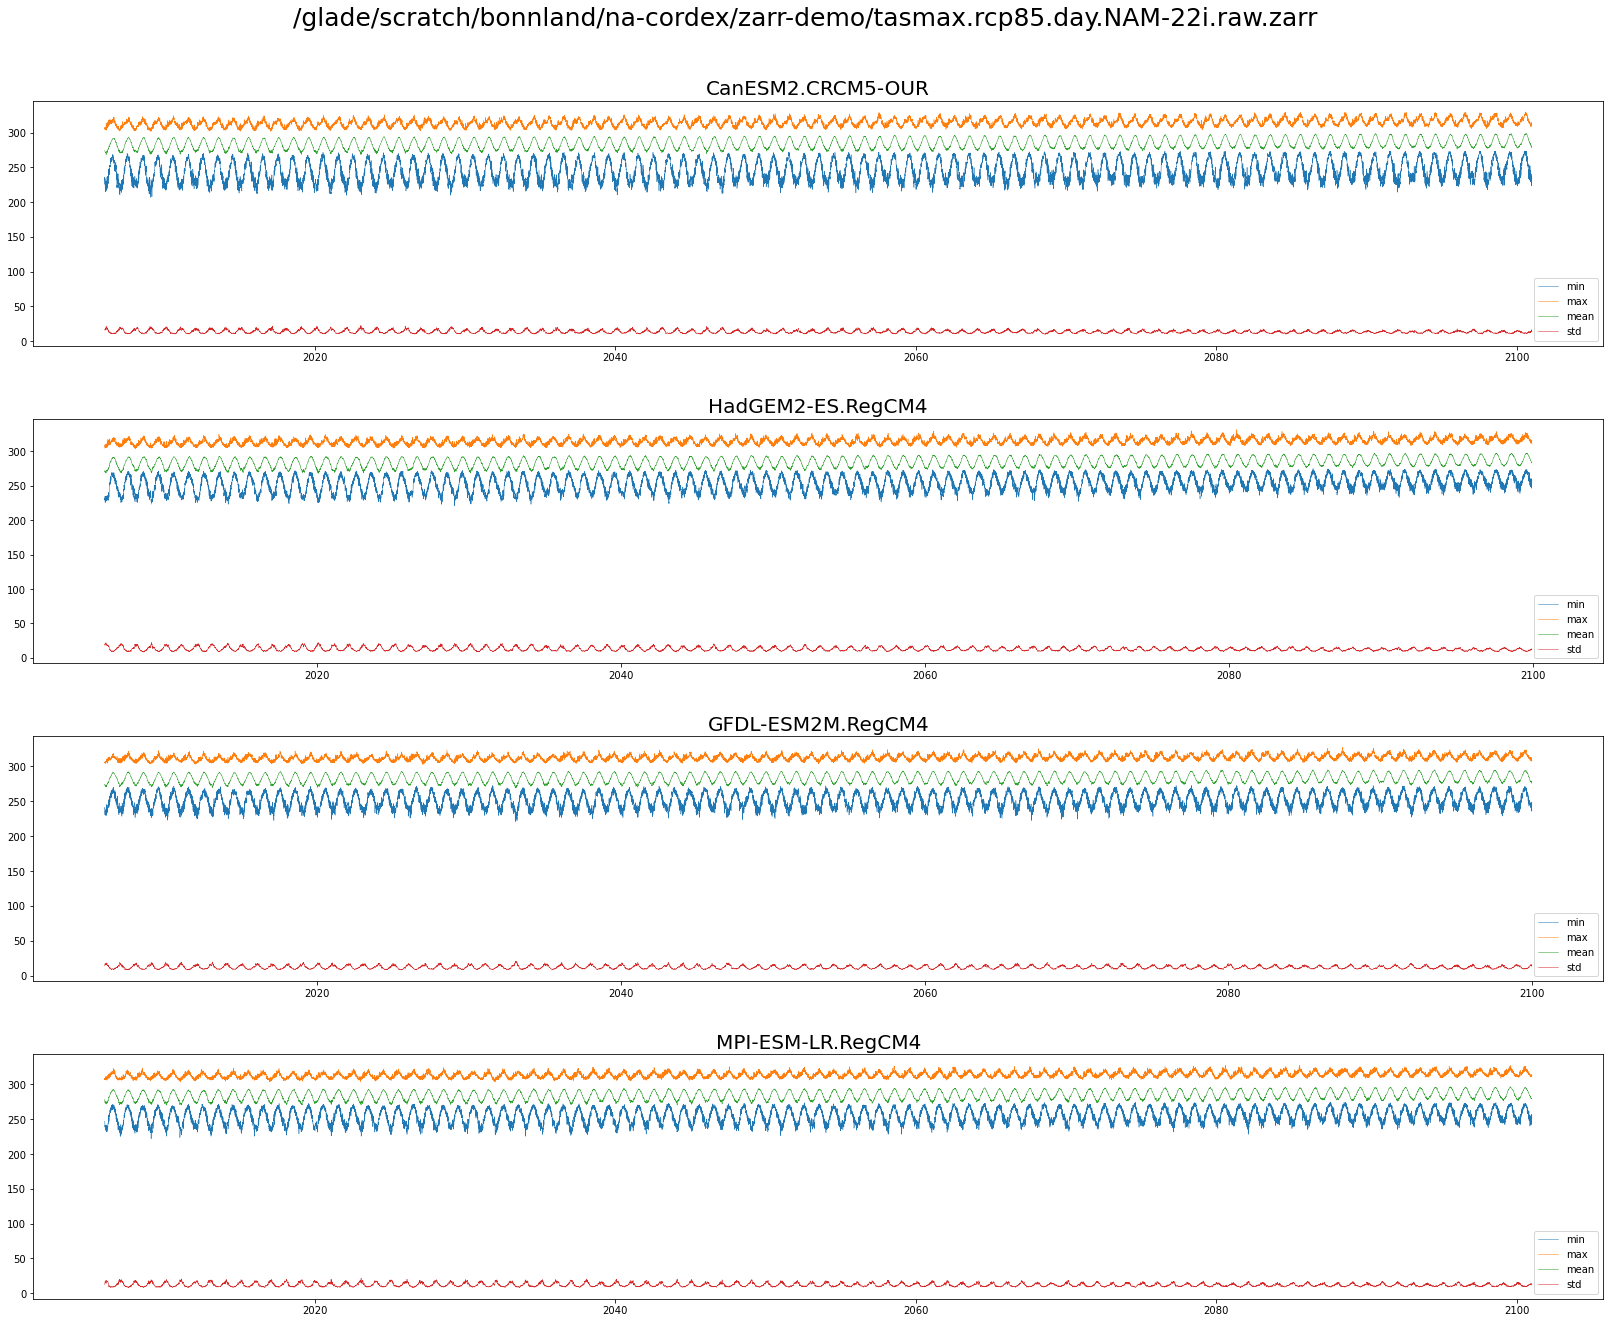

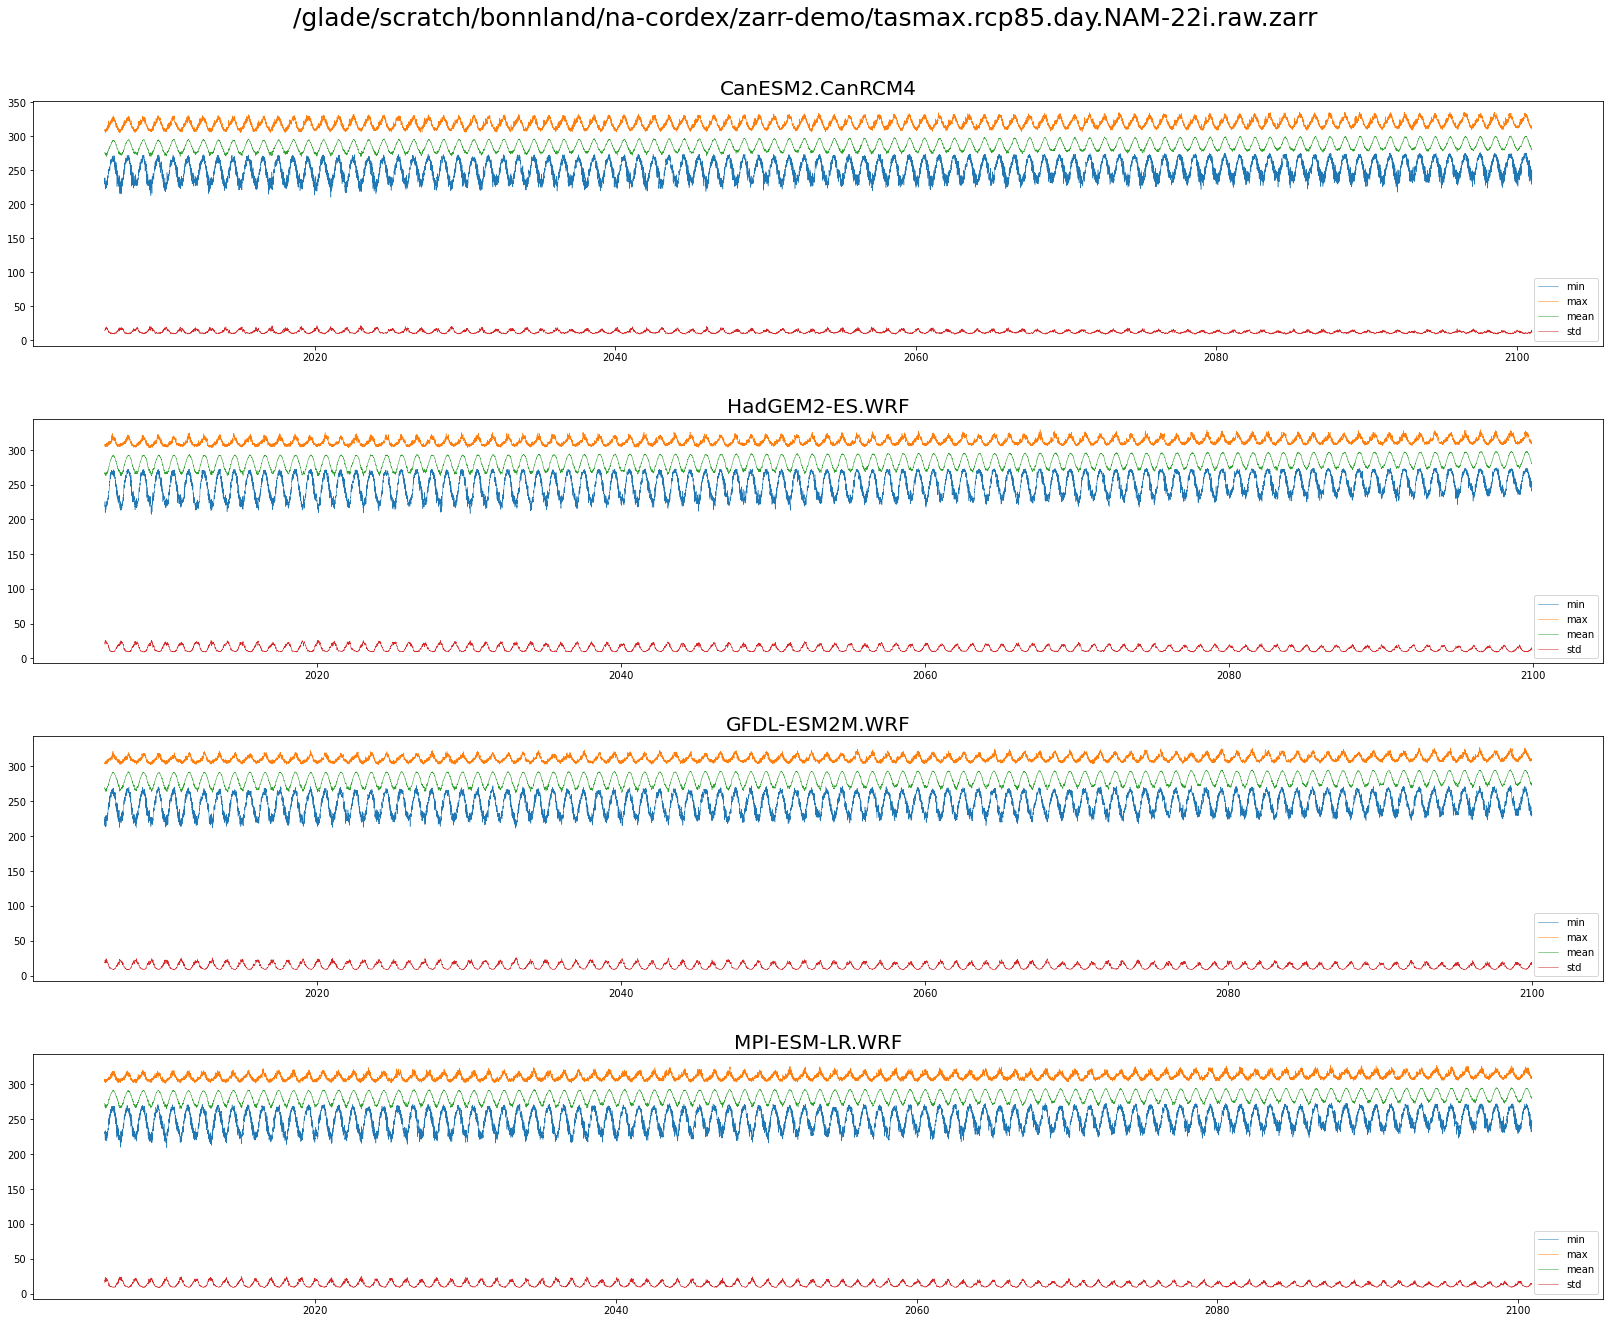

In [13]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

# Generate plot. 
#
# With 30 workers, expect 1 minute walltime for computation and 1-2 minutes for plot rendering.
#
numPlotsPerPage = 4
numPages = np.ceil(numEnsembleMembers / numPlotsPerPage).astype(int)
numPlotCols = 1

figWidth = 25 
figHeight = 20

linewidth = 0.5

pp = PdfPages(f'{store_name}_ts3.pdf')


for pageNum in range(numPlotsPerPage):
    
    memberStart = pageNum * numPlotsPerPage
    memberEnd = np.min((memberStart + numPlotsPerPage, numEnsembleMembers))
    plot_row_index = 0

    # Plot the minimums across time.
    fig, axs = plt.subplots(numPlotsPerPage, numPlotCols, figsize=(figWidth, figHeight))
    for index in np.arange(memberStart, memberEnd):
        mem_id = member_names[index]
        data_slice = ds[data_var].sel(member_id=mem_id)

        min_vals = data_slice.min(dim = ['lat', 'lon'])
        max_vals = data_slice.max(dim = ['lat', 'lon'])
        mean_vals = data_slice.mean(dim = ['lat', 'lon'])
        std_vals = data_slice.std(dim = ['lat', 'lon'])

        axs[plot_row_index].plot(ds.time, min_vals, linewidth=linewidth, label='min')
        axs[plot_row_index].plot(ds.time, max_vals, linewidth=linewidth, label='max')
        axs[plot_row_index].plot(ds.time, mean_vals, linewidth=linewidth, label='mean')
        axs[plot_row_index].plot(ds.time, std_vals, linewidth=linewidth, label='std')
        axs[plot_row_index].set_title(mem_id, fontsize=20)
        axs[plot_row_index].legend(loc='lower right')
        
        plot_row_index = plot_row_index + 1

    plt.suptitle(store, fontsize=25)
    plt.tight_layout(pad=10.2, w_pad=3.5, h_pad=3.5)

    pp.savefig()
        
pp.close()

### Release the workers.

In [14]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
